In [ ]:
from jupyter_utils import jupyter_setup
jupyter_setup()
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision.models import resnet18, resnet50, ResNet18_Weights, ResNet50_Weights
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

# Set the learning rate for each layer
For transfer learning/fine tuning it is advantageous if the model retains most of the learned parameters in the early layers (more abstract representations like shapes). This can be achieved by setting the lr very small for early layers and higher for later layers. The extreme of that would be to freeze some layers (or all except for the classification layer)

In [ ]:
def get_parameter_groups(model, output_lr, input_lr, weight_decay=1e-4, verbose=True):
    # applies different learning rates for each (parent) layer in the model (for finetuning a pretrained network).
    # the inout layer gets the input_lr, the output layer the output_lr. All layers in between get linearly interpolated.

    # works for resnet architecture and assigns a learning rate for each parent layer and the input and output layers
    # in total there are (for a resnet 18) 61 parameter groups but only 4 parent layers and 3 layers as input/output layers
    # this means there are only  4+3  different learning rates.
    
    parent_layer = lambda name: name.split(".")[0]    
    layer_names = [name for name, _ in model.named_parameters()]
    layer_names.reverse()
    parent_layers = list(set([parent_layer(layer) for layer in layer_names]))
    n_parent_layers = len(parent_layers)
    lr=output_lr
    last_parent_layer = parent_layer(layer_names[0])
    if verbose:
        print(f'0: lr = {lr:.6f}, {last_parent_layer}')
    
    lr_mult = np.power(input_lr/output_lr, 1/(n_parent_layers-1))
    parameters = []
    for idx, layer in enumerate(layer_names):
        current_parent_layer = parent_layer(layer)
        if last_parent_layer != (current_parent_layer):
            lr *= lr_mult
            if verbose:
                print(f'{idx}: lr = {lr:.6f}, {current_parent_layer}')
            last_parent_layer = current_parent_layer
        parameters.append({'params': [p for n, p in model.named_parameters() if n == layer and p.requires_grad],
                           'lr':     lr,
                           'weight_decay': weight_decay})
    return parameters

In [87]:
my_model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [ ]:
parameters = get_parameter_groups(my_model, output_lr=1e-3, input_lr=5e-5, verbose=True)

In [ ]:
optimizer = Adam(parameters)

In [ ]:
lr_scheduler = ExponentialLR(optimizer, gamma=0.5)

In [ ]:
for group in optimizer.param_groups:
    print(group["lr"])

In [ ]:
optimizer.step()
lr_scheduler.step()

In [ ]:
for group in optimizer.param_groups:
    print(group["lr"])

# Change the number of input channels
The pretrained resnet was trained on RGB images. Hence it has 3 input channels, for each color 1. I only have 1 channel, so what to do with the pretrained weights?

In [88]:
my_model.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [89]:
my_model.conv1.kernel_size

(7, 7)

In [90]:
weights = my_model.conv1.weight
weights.shape

torch.Size([64, 3, 7, 7])

## create a single channel that has the mean of the 3 RGB channel weights

In [91]:
weights_single_channel = weights.mean(dim=1).unsqueeze(dim=1)
weights_single_channel.shape

torch.Size([64, 1, 7, 7])

## create a single channel that has the channel weights of channel 0 (red cahnnel i guess)

In [ ]:
weights_single_color = weights[:, 0, :, :].unsqueeze(dim=1)
weights_single_color.shape

In [92]:
in_channels = 1
out_channels = 64
my_model.conv1 = nn.Conv2d(in_channels, out_channels , kernel_size=7, stride=2, padding=3, bias=False)

In [93]:
my_model.conv1.weight = nn.Parameter(weights_single_channel)

# add dropout after each parent layer in resnet (everytime downsampling is applied)

In [104]:
my_model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [105]:
my_model.layer1 = nn.Sequential(*my_model.layer1, nn.Dropout2d(p=0.1))
my_model.layer2 = nn.Sequential(*my_model.layer2, nn.Dropout2d(p=0.2))
my_model.layer3 = nn.Sequential(*my_model.layer3, nn.Dropout2d(p=0.3))
my_model.layer4 = nn.Sequential(*my_model.layer4, nn.Dropout2d(p=0.4))
my_model.avgpool = nn.Sequential(my_model.avgpool, nn.Dropout(p=0.5))

In [106]:
layer_names = [name for name, _ in my_model.named_parameters()]
my_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [102]:
m = nn.Dropout2d(p=.0)
input = torch.randn(5, 3, 10, 10)
output = m(input)

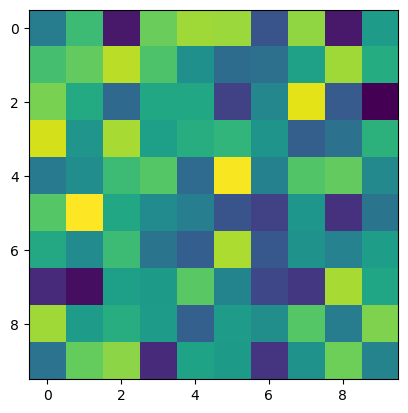

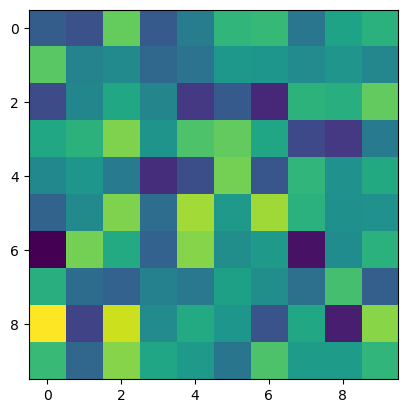

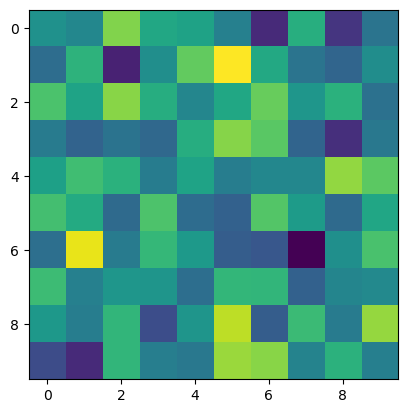

In [103]:
i = 1
plt.imshow(output[i, 0])
plt.figure()
plt.imshow(output[i, 1])
plt.figure()
plt.imshow(output[i, 2])

In [132]:
output = my_model.layer4(torch.randn(2, 256, 25, 25))

154


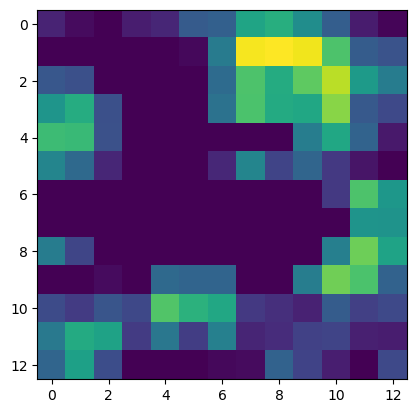

In [151]:
i = np.random.randint(256)
print(i)
plt.imshow(output[0, i].detach().numpy())
# plt.figure()
# plt.imshow(output[i, 1])

In [155]:
my_model(torch.randn(2, 3, 224, 224))

tensor([[ 4.7952, -3.2419,  3.0388,  ...,  5.0536,  0.4354, -1.8299],
        [-3.0323,  2.5517,  1.9307,  ..., -0.5568,  0.7291, -0.8353]],
       grad_fn=<AddmmBackward0>)